In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import kruskal
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout
from prophet import Prophet

import math
from sklearn.metrics import mean_squared_error


In [2]:
df = pd.read_csv("RBIDATA.csv")

In [3]:
df.head()

,Date,Bank Name,Atm's on-site,Atm's off-site,Credit card cash withdraw,Debit card cash withdraw
0,Jan2025,BANK OF BARODA,8504.0,2411.0,63510.0,120380330.0
1,Jan2025,BANK OF INDIA,5341.0,2895.0,29163.0,63783084.0
2,Jan2025,BANK OF MAHARASHTRA,2197.0,252.0,3709.0,29366539.0
3,Jan2025,CANARA BANK,8174.0,3794.0,560312.0,150843429.0
4,Jan2025,CENTRAL BANK OF INDIA,2857.0,1144.0,0.0,39560576.0


In [4]:
df["Date"] = pd.to_datetime(df["Date"], format="%b%Y")
print(df.head())

        Date              Bank Name  Atm's on-site  Atm's off-site  \
0 2025-01-01         BANK OF BARODA         8504.0          2411.0   
1 2025-01-01          BANK OF INDIA         5341.0          2895.0   
2 2025-01-01    BANK OF MAHARASHTRA         2197.0           252.0   
3 2025-01-01            CANARA BANK         8174.0          3794.0   
4 2025-01-01  CENTRAL BANK OF INDIA         2857.0          1144.0   

   Credit card cash withdraw  Debit card cash withdraw  
0                    63510.0               120380330.0  
1                    29163.0                63783084.0  
2                     3709.0                29366539.0  
3                   560312.0               150843429.0  
4                        0.0                39560576.0  


In [5]:
df["Bank Name"].unique()

array(['BANK OF BARODA', 'BANK OF INDIA', 'BANK OF MAHARASHTRA',
       'CANARA BANK', 'CENTRAL BANK OF INDIA', 'INDIAN BANK',
       'INDIAN OVERSEAS BANK', 'PUNJAB AND SIND BANK',
       'PUNJAB NATIONAL BANK', 'STATE BANK OF INDIA', 'UCO BANK',
       'UNION BANK OF INDIA', 'AXIS BANK LTD', 'BANDHAN BANK LTD',
       'CITY UNION BANK', 'CSB BANK LTD', 'DCB BANK LTD',
       'DHANALAKSHMI BANK LTD', 'FEDERAL BANK LTD', 'HDFC BANK LTD',
       'ICICI BANK LTD', 'IDBI BANK LTD', 'IDFC FIRST BANK LTD',
       'INDUSIND BANK LTD', 'JAMMU AND KASHMIR BANK LTD',
       'KARNATAKA BANK LTD', 'KARUR VYSYA BANK LTD',
       'KOTAK MAHINDRA BANK LTD', 'NAINITAL BANK LTD', 'RBL BANK LTD',
       'SOUTH INDIAN BANK', 'TAMILNAD MERCANTILE BANK LTD',
       'YES BANK LTD', 'IDFC Bank Limited', 'THE LAXMI VILAS BANK LTD',
       'ALLAHABAD BANK', 'ANDHRA BANK', 'CORPORATION BANK',
       'ORIENTAL BANK OF COMMERCE', 'SYNDICATE BANK',
       'UNITED BANK OF INDIA', 'DENA BANK', 'VIJAYA BANK',
      

#### Lets look for Bank of baroda data

In [6]:
bobdf = df[df["Bank Name"] == "BANK OF BARODA"]
bobdf.head()

,Date,Bank Name,Atm's on-site,Atm's off-site,Credit card cash withdraw,Debit card cash withdraw
0,2025-01-01,BANK OF BARODA,8504.0,2411.0,63510.0,120380330.0
33,2024-12-01,BANK OF BARODA,8395.0,2383.0,66327.0,118048467.0
66,2024-11-01,BANK OF BARODA,8345.0,2343.0,64370.0,111001788.0
99,2024-10-01,BANK OF BARODA,8217.0,2256.0,69214.0,135255138.0
132,2024-09-01,BANK OF BARODA,8107.0,2253.0,62629.0,112190265.0


In [7]:
# Set "Date" as index and reverse the order
bobdf.set_index("Date", inplace=True)
bobdf = bobdf[::-1]  # Reverse the order
bobdf.head()

,Bank Name,Atm's on-site,Atm's off-site,Credit card cash withdraw,Debit card cash withdraw
Date,,,,,
2017-01-01,BANK OF BARODA,6287.0,4146.0,16.7,50090.50
2017-02-01,BANK OF BARODA,6276.0,4203.0,22.7,61315.50
2017-03-01,BANK OF BARODA,6296.0,4224.0,25.5,69927.10
2017-04-01,BANK OF BARODA,6307.0,4212.0,22.2,66622.01
2017-05-01,BANK OF BARODA,6336.0,4216.0,21.7,65557.20


In [8]:
bobdf.index.dtype

dtype('<M8[ns]')

#### Values in the column "Credit card cash withdraw", "Debit card cash withdraw" vary in 3 formats
1. Mar2022-Jan2025 are in 000's  
2. Jul2019-Feb2022 are in lakhs
3. Jan2017-Jun2019 are in millions 

In [9]:
def convert_values(row):
    date = row.name  # since 'Date' is now the index
    
    if pd.Timestamp('2022-03-01') <= date <= pd.Timestamp('2025-01-01'):
        multiplier = 1000
    elif pd.Timestamp('2019-07-01') <= date <= pd.Timestamp('2022-02-28'):
        multiplier = 100000
    elif pd.Timestamp('2017-01-01') <= date <= pd.Timestamp('2019-06-30'):
        multiplier = 1000000
    else:
        multiplier = 1  # Default

    row['Credit card cash withdraw'] *= multiplier
    row['Debit card cash withdraw'] *= multiplier
    return row

# Apply the conversion
bobdf = bobdf.apply(convert_values, axis=1)

In [10]:
bobdf.to_csv("bobdf.csv")

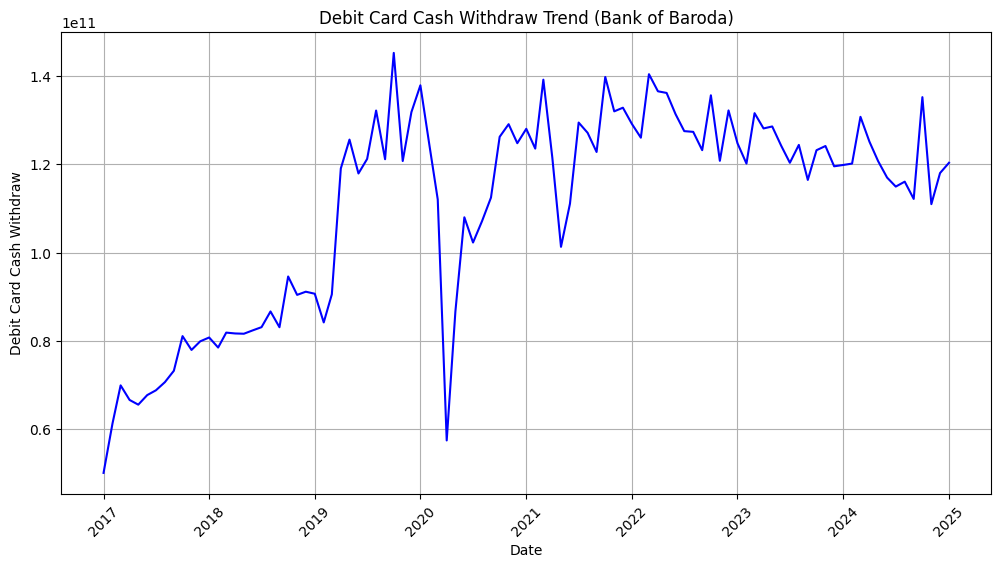

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(bobdf.index, bobdf["Debit card cash withdraw"], linestyle="-", color="b")
plt.xlabel("Date")
plt.ylabel("Debit Card Cash Withdraw")
plt.title("Debit Card Cash Withdraw Trend (Bank of Baroda)")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)

# Show the plot
plt.show()

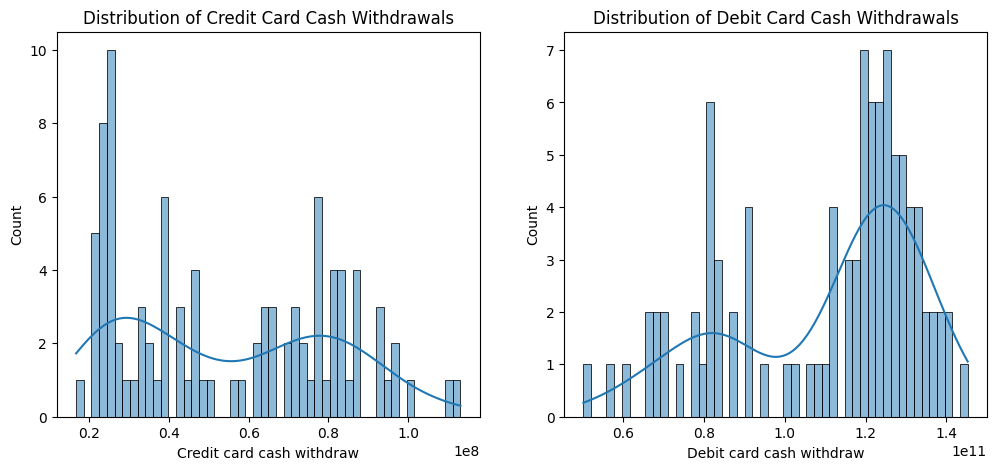

In [12]:
# Plot distribution for both columns
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(bobdf["Credit card cash withdraw"], kde=True, bins=50)
plt.title("Distribution of Credit Card Cash Withdrawals")

plt.subplot(1, 2, 2)
sns.histplot(bobdf["Debit card cash withdraw"], kde=True, bins=50)
plt.title("Distribution of Debit Card Cash Withdrawals")

plt.show()


we see data is not normally distributed and hence we will apply min-max scaling 

In [13]:
# Select numeric columns for scaling
cols_to_scale = ["Debit card cash withdraw"]

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Apply scaler
bobdf[cols_to_scale] = scaler.fit_transform(bobdf[cols_to_scale])

# Display first 5 rows after scaling
print(bobdf.head())

                 Bank Name  Atm's on-site  Atm's off-site  \
Date                                                        
2017-01-01  BANK OF BARODA         6287.0          4146.0   
2017-02-01  BANK OF BARODA         6276.0          4203.0   
2017-03-01  BANK OF BARODA         6296.0          4224.0   
2017-04-01  BANK OF BARODA         6307.0          4212.0   
2017-05-01  BANK OF BARODA         6336.0          4216.0   

            Credit card cash withdraw  Debit card cash withdraw  
Date                                                             
2017-01-01                 16700000.0                  0.000000  
2017-02-01                 22700000.0                  0.117916  
2017-03-01                 25500000.0                  0.208379  
2017-04-01                 22200000.0                  0.173660  
2017-05-01                 21700000.0                  0.162474  


# Decomposing the time series 

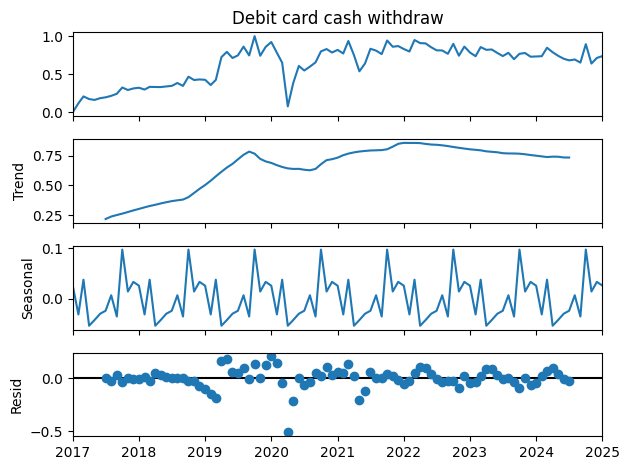

In [14]:
# Decomposing the time series
decomp = seasonal_decompose(bobdf["Debit card cash withdraw"], model="additive",period=12)
decomp.plot()
plt.show()

Interpretations:
1. there is a increasing trend in the series. The trend component shows a gradual rise until 2020 and then a decline. Overall trend is seen. 

In [17]:
bobdf['month'] = bobdf.index.month

# Create monthly groups of 'Debit card cash withdraw' values
groups = [group['Debit card cash withdraw'].values for name, group in bobdf.groupby('month')]
stat, p = kruskal(*groups)
print(f"Kruskal-Wallis H-test: H = {stat:.3f}, p = {p:.3f}")

Kruskal-Wallis H-test: H = 7.452, p = 0.761


1. No significant seasonality detected (withdrawal patterns same across months)

# ARIMA MODEL 

## Making data trend stationary

In [19]:
# ADF Test
adf_test = adfuller(bobdf["Debit card cash withdraw"])
print(f"ADF Test p-value: {adf_test[1]}") # p-value < 0.05 -> Stationary)
# KPSS Test
kpss_test = kpss(bobdf["Debit card cash withdraw"], regression="c")
print(f"KPSS Test p-value: {kpss_test[1]}")  # p-value < 0.05 -> Non-Stationary

ADF Test p-value: 0.1203140776246101
KPSS Test p-value: 0.01


/var/folders/8h/xtp_v7md6bs9195xxzbbf5d80000gn/T/ipykernel_1819/2123331913.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(bobdf["Debit card cash withdraw"], regression="c")


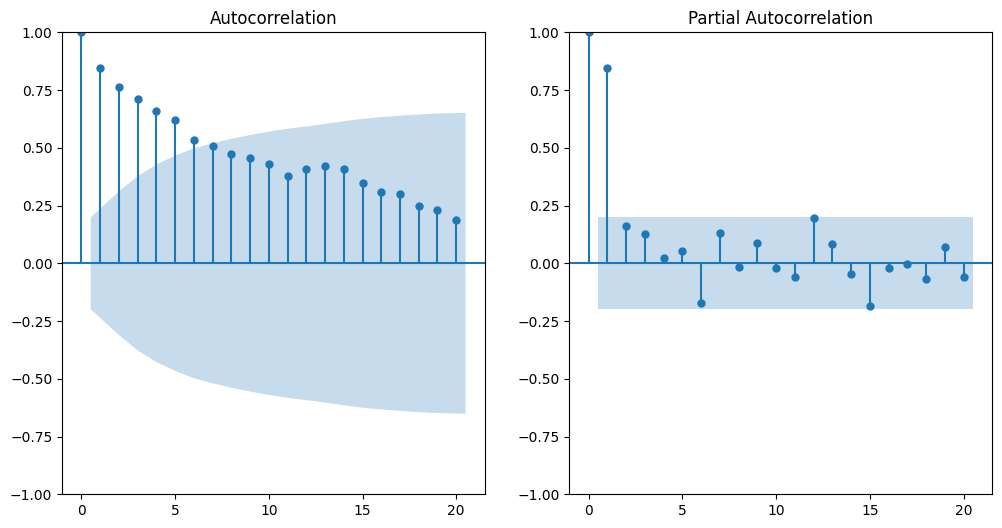

In [20]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plot_acf(bobdf["Debit card cash withdraw"], lags=20, ax=plt.gca())  
plt.subplot(122)
plot_pacf(bobdf["Debit card cash withdraw"], lags=20, ax=plt.gca())  
plt.show()

Series is not stationary (both kpss and adf tests says that)

In [21]:
# applying first order differencing
bobdf["diff"] = bobdf["Debit card cash withdraw"].diff().dropna()
bobdf.head()

,Bank Name,Atm's on-site,Atm's off-site,Credit card cash withdraw,Debit card cash withdraw,month,diff
Date,,,,,,,
2017-01-01,BANK OF BARODA,6287.0,4146.0,16700000.0,0.000000,1,NaN
2017-02-01,BANK OF BARODA,6276.0,4203.0,22700000.0,0.117916,2,0.117916
2017-03-01,BANK OF BARODA,6296.0,4224.0,25500000.0,0.208379,3,0.090463
2017-04-01,BANK OF BARODA,6307.0,4212.0,22200000.0,0.173660,4,-0.034719
2017-05-01,BANK OF BARODA,6336.0,4216.0,21700000.0,0.162474,5,-0.011186


In [22]:
# ADF Test
adf_test = adfuller(bobdf["diff"].dropna())
print(f"ADF Test p-value: {adf_test[1]}")  # p-value < 0.05 -> Stationary

# KPSS Test
kpss_test = kpss(bobdf["diff"].dropna(),regression="c")
print(f"KPSS Test p-value: {kpss_test[1]}")  # p-value < 0.05 -> Non-Stationary

ADF Test p-value: 2.9075832698121128e-05
KPSS Test p-value: 0.1


/var/folders/8h/xtp_v7md6bs9195xxzbbf5d80000gn/T/ipykernel_1819/2942459062.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(bobdf["diff"].dropna(),regression="c")


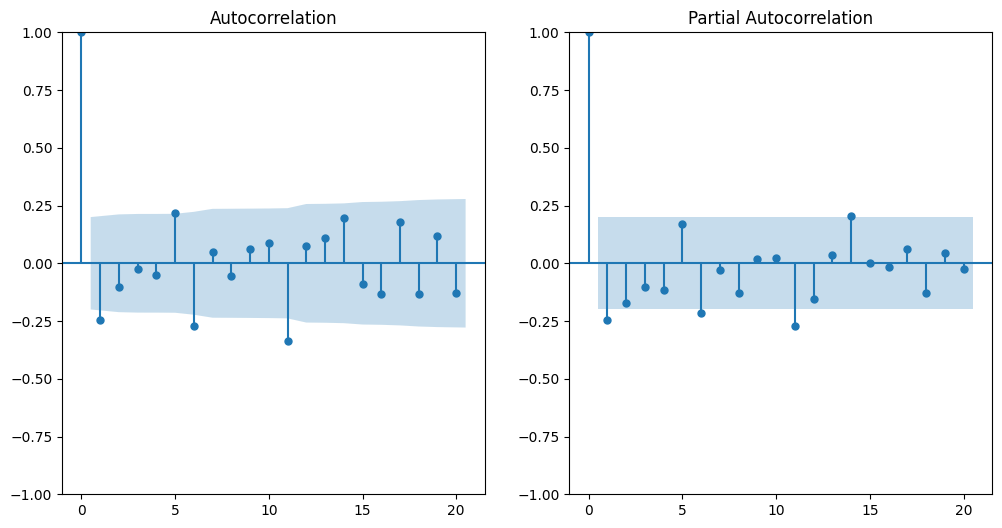

In [23]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plot_acf(bobdf["diff"].dropna(), lags=20, ax=plt.gca())  
plt.subplot(122)
plot_pacf(bobdf["diff"].dropna(), lags=20, ax=plt.gca())  
plt.show()

Interpretation:
1. Series is stationary now. tests are preffered more over plots will assume that the serie is stationary and also verify p,q values using autoarima
2. p value = 1 since there is direct drop from the first lag itself (pacf plot)
3. q value = 1 since there is direct drop from the first lag itself (acf plot) 
4. d value = 1 since series become stationary after first differencing


## Using AutoArima to determine p,d and q values

In [24]:
auto_model = auto_arima(bobdf['Debit card cash withdraw'],  
                   seasonal=True,  # SARIMA ke liye True
                   m=12,           # Seasonal period (monthly data ke liye 12)
                   stepwise=True,  # Efficient search
                   trace=True)     # Process ko print karega


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-133.464, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-132.002, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-133.946, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-136.796, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-133.603, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=-138.710, Time=0.02 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-136.803, Time=0.06 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-139.721, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-138.088, Time=0.19 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-138.027, Time=0.30 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=-137.444, Time=0.37 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-135.887, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=-137.929, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[12]

We can see from the results of the Auto arima that the AIC value for 
1. 1,1,1 is AIC = 2508.659 (what we determined)
2. 0,1,1 is AIC = AIC=2507.802 (autoarima suggested)
3. P D and Q values = 0, 0, 0. D=0 shows there is no strong seasonality present in the time series 

In [26]:
print(auto_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   97
Model:               SARIMAX(0, 1, 1)   Log Likelihood                  71.910
Date:                Mon, 07 Apr 2025   AIC                           -139.821
Time:                        19:56:31   BIC                           -134.692
Sample:                    01-01-2017   HQIC                          -137.748
                         - 01-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3469      0.098     -3.549      0.000      -0.538      -0.155
sigma2         0.0131      0.001     12.358      0.000       0.011       0.015
Ljung-Box (L1) (Q):                   0.13   Jarque-

## training the Model and forecasting value

In [27]:
# Fit ARIMA Model with selected (p,d,q)
arima_model = ARIMA(bobdf["Debit card cash withdraw"], order=(1,1,1))
arima_result = arima_model.fit()

# Forecast next 12 months
forecast = arima_result.forecast(steps=12)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [28]:
forecast

2025-02-01    0.733281
2025-03-01    0.731059
2025-04-01    0.730091
2025-05-01    0.729669
2025-06-01    0.729485
2025-07-01    0.729405
2025-08-01    0.729370
2025-09-01    0.729355
2025-10-01    0.729348
2025-11-01    0.729345
2025-12-01    0.729344
2026-01-01    0.729343
Freq: MS, Name: predicted_mean, dtype: float64

In [29]:
# Get fitted values (in-sample predictions)
fitted_values = arima_result.fittedvalues

# Visualization 

In [30]:
# Generate forecast index for next 12 months
forecast_index = pd.date_range(start=bobdf.index[-1], periods=13, freq="MS")[1:]

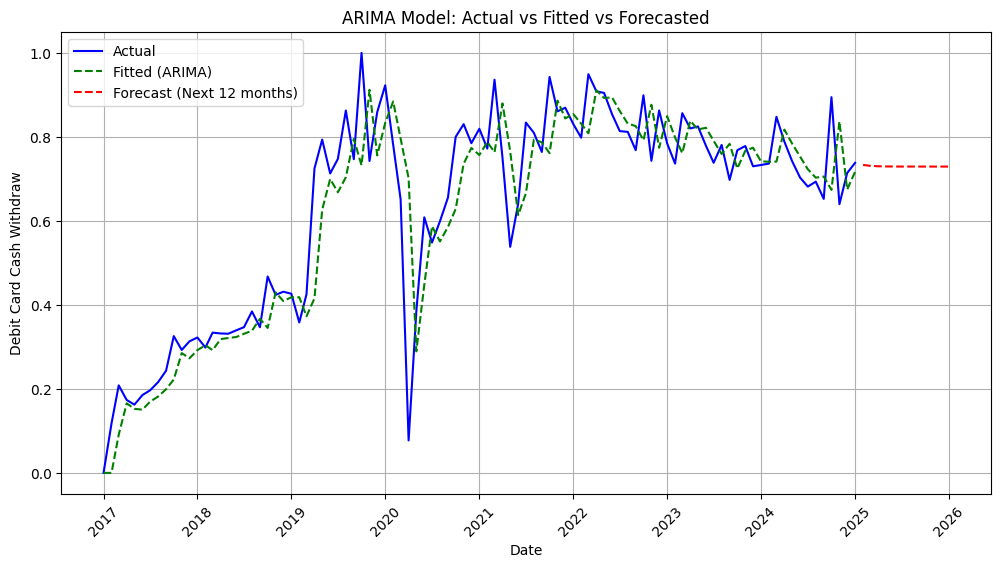

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(bobdf.index, bobdf["Debit card cash withdraw"], label="Actual", color="blue")
plt.plot(bobdf.index, fitted_values, label="Fitted (ARIMA)", color="green", linestyle="dashed")
plt.plot(forecast_index, forecast, label="Forecast (Next 12 months)", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Debit Card Cash Withdraw")
plt.title("ARIMA Model: Actual vs Fitted vs Forecasted")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [32]:
mape = np.mean(np.abs((bobdf["Debit card cash withdraw"] - fitted_values) / bobdf["Debit card cash withdraw"])) * 100

print(f"MAPE: {mape:.2f}%")


MAPE: 20.18%


Auto arima determined pdq values were forecasting same values (a central value) Since it was not considering past values (p). To overcome this problem, model was fed (1,1,1) p,d,q values and not (0,1,1)

# LSTM

In [33]:
data = bobdf["Debit card cash withdraw"].values
data = data.reshape(-1, 1)
data

array([[0.        ],
       [0.11791625],
       [0.20837929],
       [0.17366002],
       [0.16247442],
       [0.18527401],
       [0.19664124],
       [0.21603728],
       [0.2431617 ],
       [0.32566841],
       [0.29274535],
       [0.31324124],
       [0.32238566],
       [0.29848307],
       [0.33401551],
       [0.33198809],
       [0.33133994],
       [0.33944964],
       [0.34697632],
       [0.38438282],
       [0.34680299],
       [0.46763328],
       [0.42386087],
       [0.43141697],
       [0.4265606 ],
       [0.35828158],
       [0.42515296],
       [0.72475058],
       [0.79356325],
       [0.71291064],
       [0.74754892],
       [0.86279685],
       [0.74685697],
       [1.        ],
       [0.74257732],
       [0.85897059],
       [0.92282783],
       [0.78128736],
       [0.65116664],
       [0.07728058],
       [0.38422   ],
       [0.60858548],
       [0.54852435],
       [0.59932971],
       [0.65553033],
       [0.80016131],
       [0.83024913],
       [0.785

In [34]:
data.shape

(97, 1)

In [35]:
# Define function to create sequences (sliding window method)
def create_sequences(data, time_steps=12):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

In [36]:
TIME_STEPS = 12  
X, y = create_sequences(data, TIME_STEPS) # Create sequences

In [37]:
X.shape

(85, 12, 1)

In [38]:
y.shape

(85, 1)

In [39]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [40]:
# Reshape X for LSTM input (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [41]:
X_train.shape

(68, 12, 1)

In [42]:
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(TIME_STEPS, 1)),
    Dropout(0.2),
    LSTM(100, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dense(50),
    Dense(1)
])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [43]:
from keras.optimizers import Adam

opt = Adam(learning_rate=0.0005)  # try lower learning rate
model.compile(optimizer=opt, loss='mean_squared_error')

In [44]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=300,           # stop after 20 epochs with no improvement
    restore_best_weights=True
)

model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - loss: 0.4937 - val_loss: 0.3349
Epoch 2/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2955 - val_loss: 0.1348
Epoch 3/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1381 - val_loss: 0.0064
Epoch 4/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0398 - val_loss: 0.1057
Epoch 5/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0937 - val_loss: 0.0868
Epoch 6/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0507 - val_loss: 0.0121
Epoch 7/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0296 - val_loss: 0.0069
Epoch 8/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0365 - val_loss: 0.0165
Epoch 9/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0485 - val_loss: 0.0132
Epoch 10/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0408 - val_loss: 0.0048
Epoch 11/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0300 - val_loss: 0.0059
Epoch 12/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0246 - val_l

In [45]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 12, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 462,005 (1.76 MB)

 Trainable params: 154,001 (601.57 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 308,004 (1.17 MB)

In [46]:
# Predict on test data
y_pred = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


In [47]:
y_pred.shape

(17, 1)

In [48]:
y_test.shape

(17, 1)

In [49]:
# Inverse transform predictions to original scale
y_pred_original = scaler.inverse_transform(y_pred)
y_test_original = scaler.inverse_transform(y_test)

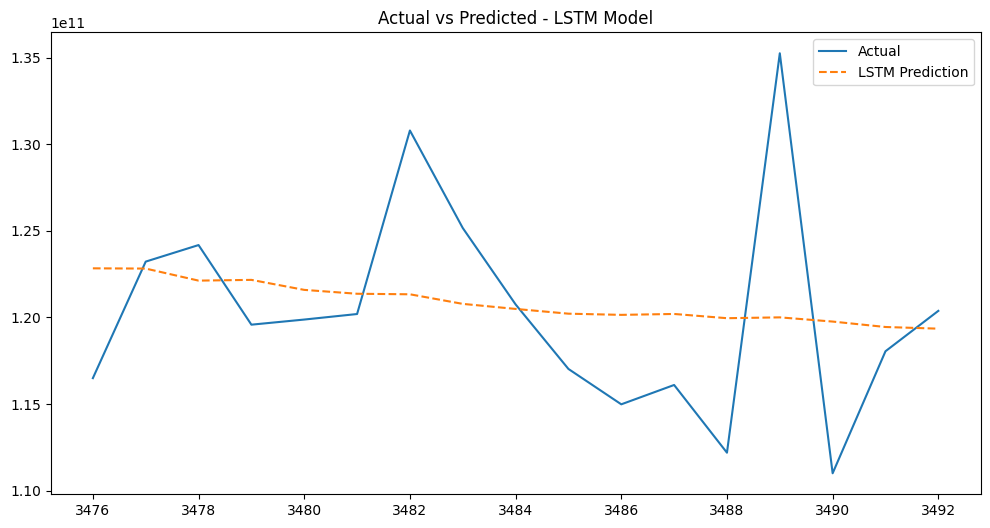

In [50]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test_original):], y_test_original, label="Actual")
plt.plot(df.index[-len(y_test_original):], y_pred_original, label="LSTM Prediction", linestyle="dashed")
plt.legend()
plt.title("Actual vs Predicted - LSTM Model")
plt.show()

In [51]:
rmse = math.sqrt(mean_squared_error(y_test_original, y_pred_original))
print("Root Mean Squared Error (RMSE):", rmse)


Root Mean Squared Error (RMSE): 5894508272.374137


In [52]:
# Avoid division by zero
mape = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100

print(f"MAPE: {mape:.2f}%")

MAPE: 3.64%


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  


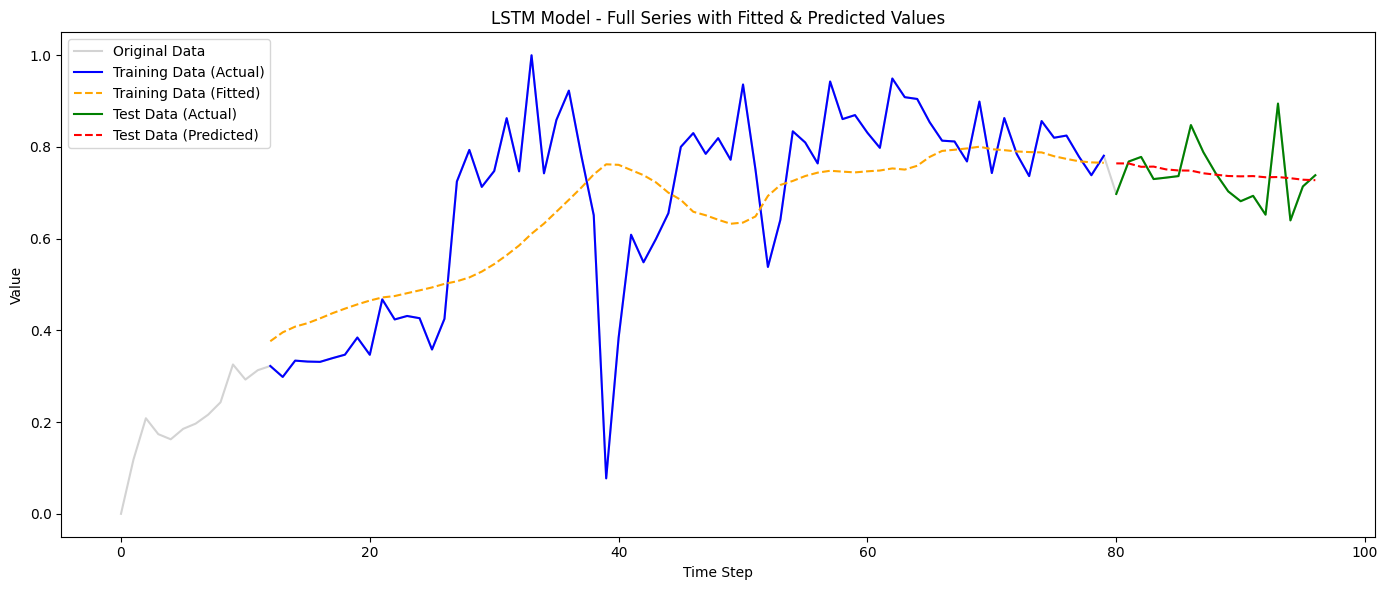

In [53]:
# Predict on training data
y_train_pred = model.predict(X_train)

# Plot the whole series with actual, fitted (train), and predicted (test)
plt.figure(figsize=(14, 6))

# Original full data (light gray for reference)
plt.plot(data, label="Original Data", color='lightgray')

# Actual training values
plt.plot(range(TIME_STEPS, TIME_STEPS + len(y_train)), y_train, label="Training Data (Actual)", color='blue')

# Fitted values (predicted on training)
plt.plot(range(TIME_STEPS, TIME_STEPS + len(y_train_pred)), y_train_pred, label="Training Data (Fitted)", linestyle='dashed', color='orange')

# Actual test values
plt.plot(range(TIME_STEPS + len(y_train), TIME_STEPS + len(y_train) + len(y_test)), y_test, label="Test Data (Actual)", color='green')

# Predicted test values
plt.plot(range(TIME_STEPS + len(y_train), TIME_STEPS + len(y_train) + len(y_pred)), y_pred, label="Test Data (Predicted)", linestyle='dashed', color='red')

plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("LSTM Model - Full Series with Fitted & Predicted Values")
plt.legend()
plt.tight_layout()
plt.show()


LSTM model would work more efficiently if size of the data was large. 

# Fbprophet

In [54]:
bobdf = bobdf[["Debit card cash withdraw"]]

In [55]:
bobdf

,Debit card cash withdraw
Date,
2017-01-01,0.000000
2017-02-01,0.117916
2017-03-01,0.208379
2017-04-01,0.173660
2017-05-01,0.162474
...,...
2024-09-01,0.652345
2024-10-01,0.894637
2024-11-01,0.639860


In [56]:
df=bobdf.reset_index()[['Date','Debit card cash withdraw']].rename({'Date':'ds','Debit card cash withdraw':'y'}, axis='columns')
df

,ds,y
0,2017-01-01,0.000000
1,2017-02-01,0.117916
2,2017-03-01,0.208379
3,2017-04-01,0.173660
4,2017-05-01,0.162474
...,...,...
92,2024-09-01,0.652345
93,2024-10-01,0.894637
94,2024-11-01,0.639860
95,2024-12-01,0.713884


In [57]:
df.shape

(97, 2)

In [58]:
df['ds'] = pd.to_datetime(df['ds'])

In [59]:
train_size = int(len(df) * 0.8)

train = df.iloc[:train_size]  
test = df.iloc[train_size:]  

In [60]:
train.shape

(77, 2)

In [61]:
test.shape

(20, 2)

In [62]:
from prophet import Prophet
model = Prophet()
model.fit(train)

20:01:16 - cmdstanpy - INFO - Chain [1] start processing
20:01:17 - cmdstanpy - INFO - Chain [1] done processing


In [63]:
model.params

OrderedDict([('lp__', array([[116.872]])),
             ('k', array([[0.892471]])),
             ('m', array([[0.21457]])),
             ('delta',
              array([[ 5.95340e-10,  2.75285e-10, -9.74544e-10,  7.50081e-10,
                       4.28425e-10, -1.73124e-09, -6.86843e-10,  4.70688e-10,
                      -1.41884e-05, -7.22234e-05, -1.35112e-06, -6.10016e-04,
                      -2.90656e-02, -2.41198e-01, -7.88531e-04, -9.96595e-05,
                      -2.16103e-04, -8.35772e-05, -1.14906e-04, -5.12752e-05,
                      -9.20394e-05, -1.35939e-05,  3.38774e-10, -3.40061e-06,
                      -2.10631e-09]])),
             ('sigma_obs', array([[0.123702]])),
             ('beta',
              array([[-0.0243324,  0.0505963,  0.17637  , -0.287502 , -0.740111 ,
                      -0.566905 , -0.777352 ,  0.327177 , -0.0198466,  0.0688112,
                       0.575699 ,  0.088314 ,  0.105118 ,  0.0228342, -0.593195 ,
                      -0.420

In [64]:
# Create future dates (for len(test) periods)
future = model.make_future_dataframe(periods=len(test), freq='M')

# Predict on future dates
forecast = model.predict(future)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


In [65]:
# Take only last n predictions to compare with test
predicted = forecast[['ds', 'yhat']].iloc[-len(test):].reset_index(drop=True)
actual = test[['ds', 'y']].reset_index(drop=True)

# Combine both
result = pd.concat([actual, predicted['yhat']], axis=1)

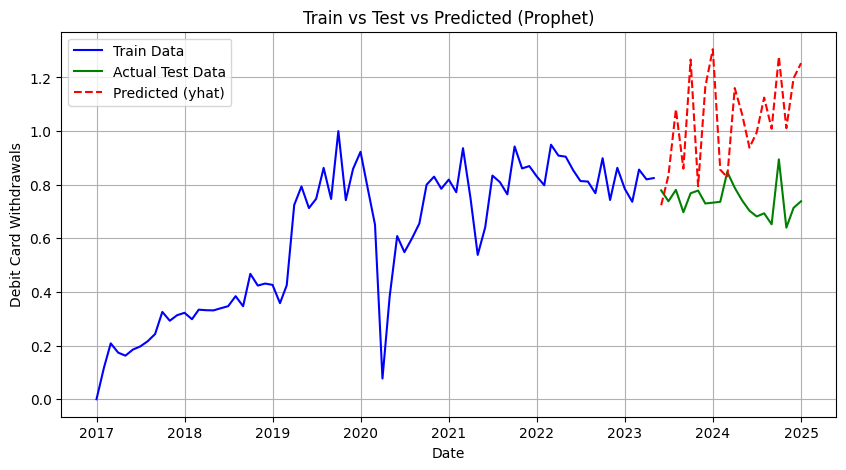

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

# Train
plt.plot(train['ds'], train['y'], label='Train Data', color='blue')

# Actual Test
plt.plot(test['ds'], test['y'], label='Actual Test Data', color='green')

# Predicted
plt.plot(result['ds'], result['yhat'], label='Predicted (yhat)', color='red', linestyle='dashed')

plt.legend()
plt.xlabel("Date")
plt.ylabel("Debit Card Withdrawals")
plt.title("Train vs Test vs Predicted (Prophet)")
plt.grid()
plt.show()


In [67]:
actual_values = test['y'].values
predicted_values = result['yhat'].values

mask = actual_values != 0
mape = np.mean(np.abs((actual_values[mask] - predicted_values[mask]) / actual_values[mask])) * 100

print(f"MAPE: {mape:.2f}%")

MAPE: 41.52%


# Synthetic data of holidays for fbprophet

In [68]:
holiday_df = pd.DataFrame({
    'holiday': [
        # COVID 1st Wave (Mar–Jun 2020)
        'covid_wave1', 

        # COVID 2nd Wave (Apr–Jun 2021)
        'covid_wave2', 

        # UPI Impact begins (Jan 2022 onward)
        'upi_surge_early', 'upi_surge_ongoing', 
    ],
    
    'ds': pd.to_datetime([
        '2020-03-01',                                                # COVID 1st wave starts
        
        '2021-04-01',                                                # COVID 2nd wave starts
        
        '2022-01-01', '2023-01-01',                                  # UPI Surge

    ]),

    # Impact range: in MONTHS!
    'lower_window': [
        0,                        # COVID wave 1 starts Mar
        0,                        # COVID wave 2 starts Apr
        0, 0,                     # UPI surge starts Jan
    ],

    'upper_window': [
        6,                        # COVID 1st wave = Mar to Jun
        3,                        # COVID 2nd wave = Apr to Jun
        12, 12,                   # UPI = long-term ongoing drop
    ]
})


In [69]:
holiday_df

,holiday,ds,lower_window,upper_window
0,covid_wave1,2020-03-01,0,6
1,covid_wave2,2021-04-01,0,3
2,upi_surge_early,2022-01-01,0,12
3,upi_surge_ongoing,2023-01-01,0,12


1. Increase in the use of UPI payment methods has reduced cash transactions. upidf is the dataframe which shows how upi transactions are increasing in terms of (No. of banks live on UPI) and (Value) as well. Altho bobdf is specific to bank of baroda and upidf is a collective data of all the banks live on it, we can compare them. Even though UPI data is national, the pattern of shift from cash to digital will likely reflect at individual bank level too.

2. Along with surge in UPI transactions, Covid 19 (wave 1) and (wave 2) also impacted the cash withdrawls.

Thus Surge in UPI transactions and impact of Covid 19 are included in holidays so that model knows about them and accordingly forecasts future values.

# Loading and processing "upidf"

In [97]:
upidf = pd.read_csv("UPI.csv")

# Convert Month column to datetime format
upidf['Date'] = pd.to_datetime(upidf['Month'], format='%b-%y')
upidf.drop(columns=['Month'], inplace=True)
upidf.head(10)

,No. of Banks live on UPI,Volume (in Mn),Value (in Cr.),Date
0,661,"18,301.51","24,77,221.61",2025-03-01
1,653,"16,106.19","21,96,481.69",2025-02-01
2,647,"16,996.00","23,48,037.12",2025-01-01
3,641,"16,730.01","23,24,699.91",2024-12-01
4,637,"15,482.02","21,55,187.40",2024-11-01
5,632,"16,584.97","23,49,821.46",2024-10-01
6,622,"15,041.75","20,63,994.71",2024-09-01
7,608,"14,963.05","20,60,735.57",2024-08-01
8,605,"14,435.55","20,64,292.41",2024-07-01
9,602,"13,885.14","20,07,081.20",2024-06-01


In [98]:
upidf.set_index("Date", inplace=True)
upidf = upidf[["No. of Banks live on UPI", "Value (in Cr.)"]]

In [99]:
upidf["Value (in Cr.)"].dtype                  # object type
upidf["Value (in Cr.)"] = (
    upidf["Value (in Cr.)"]
    .str.replace(",", "", regex=False)         # remove commas
    .astype(float)                             # convert to float
    * 10000000                                 # convert crore to actual value
)


In [100]:
upidf.head()

,No. of Banks live on UPI,Value (in Cr.)
Date,,
2025-03-01,661,2.477222e+13
2025-02-01,653,2.196482e+13
2025-01-01,647,2.348037e+13
2024-12-01,641,2.324700e+13
2024-11-01,637,2.155187e+13


<Axes: xlabel='Value (in Cr.)', ylabel='Count'>

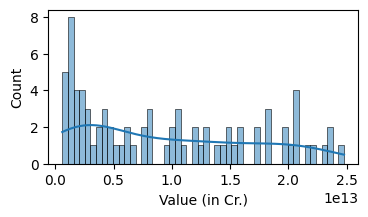

In [101]:
plt.figure(figsize=(4, 2))
sns.histplot(upidf["Value (in Cr.)"], kde=True, bins=50)

In [102]:
# Select numeric columns for scaling
cols_to_scale = ["Value (in Cr.)"]

# Apply scaler
upidf[cols_to_scale] = scaler.fit_transform(upidf[cols_to_scale])
print(upidf.head())

            No. of Banks live on UPI  Value (in Cr.)
Date                                                
2025-03-01                       661        1.000000
2025-02-01                       653        0.883866
2025-01-01                       647        0.946560
2024-12-01                       641        0.936906
2024-11-01                       637        0.866784


In [103]:
upidf.rename(columns={"Value (in Cr.)":"Values"},inplace=True)

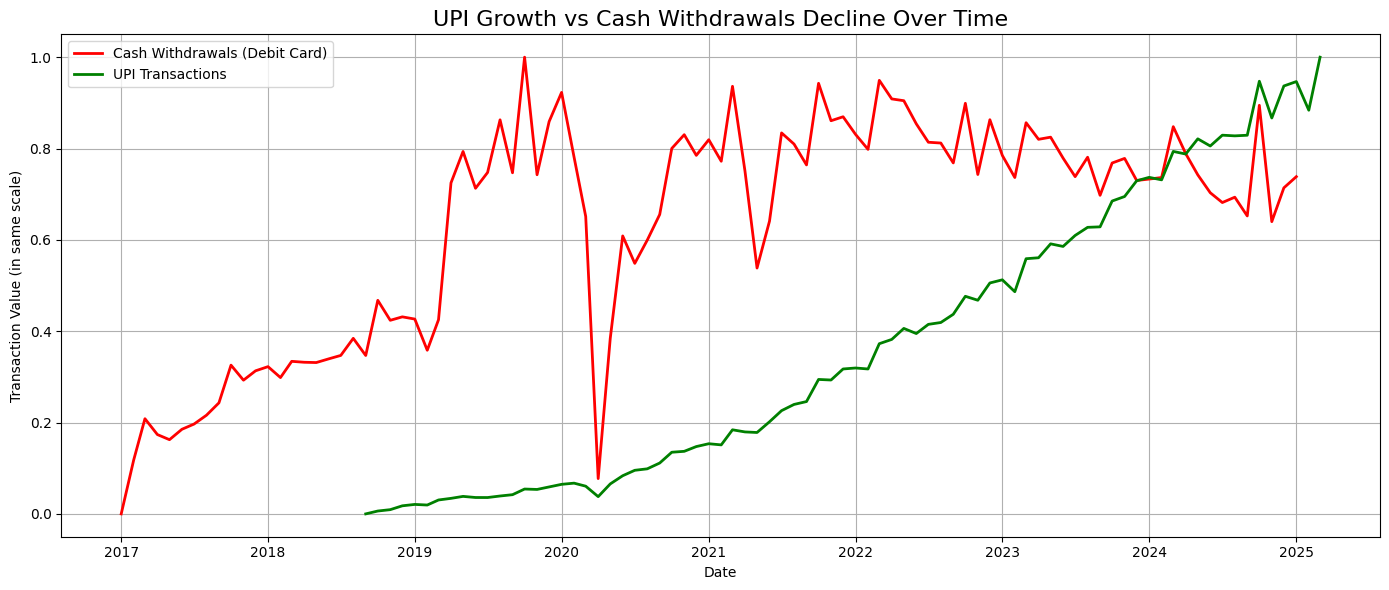

In [104]:
plt.figure(figsize=(14, 6))
plt.plot(bobdf.index, bobdf['Debit card cash withdraw'], label='Cash Withdrawals (Debit Card)', color='red', linewidth=2)
plt.plot(upidf.index, upidf['Values'], label='UPI Transactions', color='green', linewidth=2)
plt.title('UPI Growth vs Cash Withdrawals Decline Over Time', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Transaction Value (in same scale)')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


# Fbprophet

In [105]:
bobdf = bobdf[["Debit card cash withdraw"]]
df = bobdf.reset_index()[['Date', 'Debit card cash withdraw']].rename(columns={'Date': 'ds', 'Debit card cash withdraw': 'y'})
df['ds'] = pd.to_datetime(df['ds'])

In [106]:
holiday_df['ds'] = pd.to_datetime(holiday_df['ds'])

In [89]:
# Step 3: Train/Test Split
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

In [90]:
model = Prophet(holidays=holiday_df)
model.fit(train)

20:12:30 - cmdstanpy - INFO - Chain [1] start processing
20:12:30 - cmdstanpy - INFO - Chain [1] done processing


In [91]:
future = model.make_future_dataframe(periods=len(test), freq='M')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


In [92]:
forecast = model.predict(future)

In [93]:
predicted = forecast[['ds', 'yhat']].iloc[-len(test):].reset_index(drop=True)
actual = test[['ds', 'y']].reset_index(drop=True)

In [94]:
result = pd.concat([actual, predicted['yhat']], axis=1)

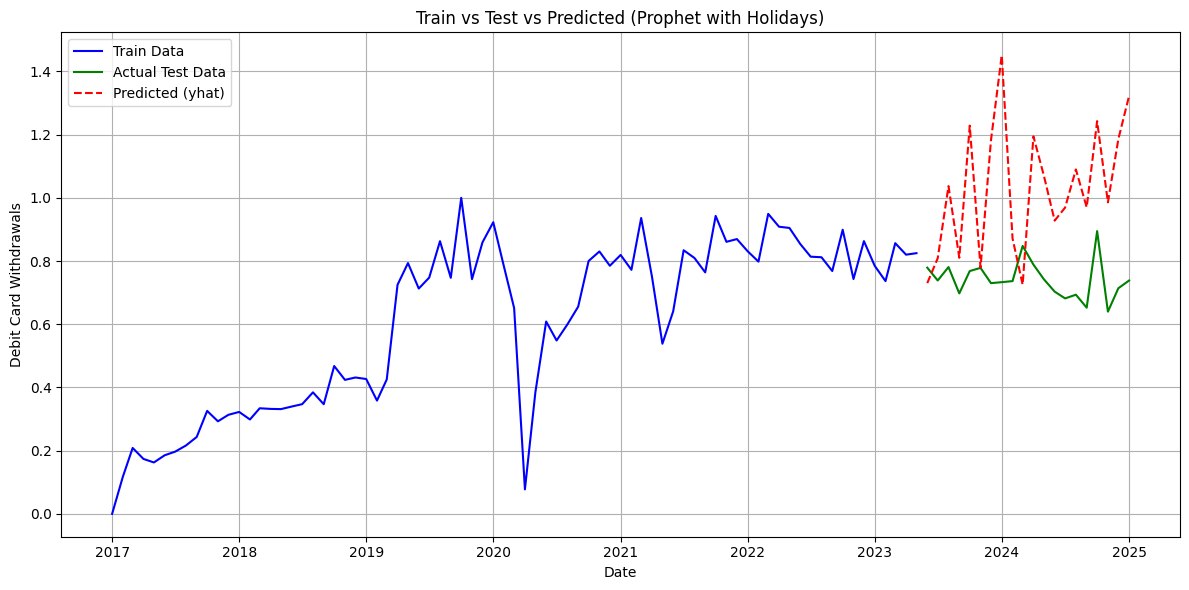

In [95]:
plt.figure(figsize=(12, 6))

plt.plot(train['ds'], train['y'], label='Train Data', color='blue')
plt.plot(test['ds'], test['y'], label='Actual Test Data', color='green')
plt.plot(result['ds'], result['yhat'], label='Predicted (yhat)', color='red', linestyle='dashed')

plt.legend()
plt.xlabel("Date")
plt.ylabel("Debit Card Withdrawals")
plt.title("Train vs Test vs Predicted (Prophet with Holidays)")
plt.grid()
plt.tight_layout()
plt.show()

In [96]:
actual_values = test['y'].values
predicted_values = result['yhat'].values

mask = actual_values != 0
mape = np.mean(np.abs((actual_values[mask] - predicted_values[mask]) / actual_values[mask])) * 100

print(f"MAPE: {mape:.2f}%")

MAPE: 41.57%


Holidays didnt imporve models performance at all. This is because model is capturing the trend and is not able to detect that after 2023 the plot is stabalizing and seems falling eventually. To capture this fall we used holidays but there seems no improvement in models performance 

# Future Work

1. The data is on macro economical scale on monthly basis and that too on national level. The daily data on atm's of a particular region would be appreciated. 
2. UPI Adoption vs. Cash Usage Correlation : A deeper analysis comparing rise in UPI transactions with decline in cash withdrawals across banks or regions.

